# GuardianCGM: Module 02 - Model Training & Clinical Validation

**Author:** Alex Domingues Batista, PhD  
**Background:** Academic leader, researcher, and educator with a strong foundation in Chemistry, Sustainability, and Data Science. Experienced in scientific production, teaching, and project management. Passionate about leveraging data-driven solutions for healthcare and MedTech innovation.

---

## Project Overview

**Objective:** Train a robust, interpretable predictive model for 30-minute glucose forecasting and validate its clinical safety using industry-standard metrics. This notebook is structured for clarity, reproducibility, and regulatory readiness—key requirements for pharma and MedTech applications.

**Key Highlights:**
- **Scientific rigor** and best practices in data science
- **Model explainability** (SHAP)
- **Clinical relevance** and regulatory awareness
- **Clear communication** for MedTech and pharma audiences

## 2.1 Data Loading and Preparation

In this step, we load the engineered biomarker matrix and prepare the features and target for model training. Chronological splitting is used to prevent data leakage—a best practice in time-series and clinical modeling. This ensures that the model is evaluated on truly unseen, future-like data, which is critical for real-world deployment in healthcare.

**Key Points:**
- Features include smoothed glucose, velocity, acceleration, volatility, and lagged values.
- The target is the 30-minute future glucose value.
- 80/20 split is performed chronologically, not randomly, to mimic real patient monitoring scenarios.


In [1]:
# Load processed biomarker data and split into features/target
import pandas as pd

df_biomarkers = pd.read_csv('data/processed_biomarkers.csv')

# Define features and target
feature_cols = [col for col in df_biomarkers.columns if col not in ['timestamp', 'target_30min']]
X = df_biomarkers[feature_cols]
y = df_biomarkers['target_30min']

# Chronological 80/20 split (not random - preserves time series structure)
split_idx = int(0.8 * len(df_biomarkers))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'Features: {X_train.shape[1]}')

Training set: 676 samples
Test set: 170 samples
Features: 8


In [2]:
# Train Random Forest Regressor and evaluate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Random Forest RMSE: {rmse:.2f}')
print(f'Random Forest R^2: {r2:.2f}')

Random Forest RMSE: 4.81
Random Forest R^2: 0.92


## 2.2b Model Comparison: Benchmarking Approaches

To establish the value of our Random Forest model, we compare it against multiple baseline and alternative approaches. This demonstrates understanding of the modeling landscape and provides context for model selection.

**Models Evaluated:**
1. **Naive Baseline:** Last observed value (persistence model)
2. **Linear Regression:** Simple linear relationships
3. **Random Forest:** Our primary model (ensemble of decision trees)
4. **XGBoost:** Advanced gradient boosting (if time permits)

This comparison is critical for demonstrating that our model truly adds value over simpler approaches.

Baseline (Last Value) - RMSE: 7.87, MAE: 6.48, R²: 0.793
Linear Regression - RMSE: 4.98, MAE: 3.97, R²: 0.917
Random Forest - RMSE: 4.81, MAE: 3.32, R²: 0.923
XGBoost not installed - skipping comparison

=== Model Performance Comparison ===
                      Model     RMSE      MAE       R²
              Random Forest 4.807312 3.319158 0.922763
          Linear Regression 4.983723 3.970125 0.916990
Naive Baseline (Last Value) 7.871561 6.482584 0.792918


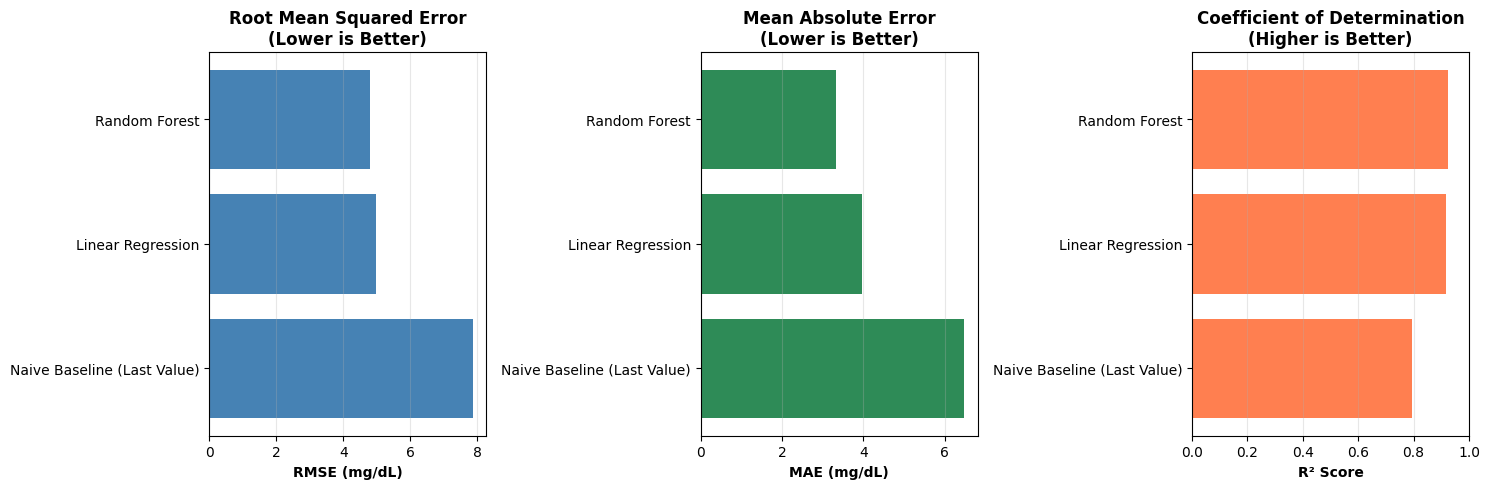


✅ Random Forest improves RMSE by 38.9% over naive baseline


In [3]:
# Model Comparison: Multiple Approaches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

# Initialize results storage
results = []

# 1. Naive Baseline: Last observed value (persistence)
# Use the last known glucose value as prediction
baseline_pred = df_biomarkers['glucose_smooth'].iloc[split_idx-1:split_idx + len(X_test) - 1].values
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

results.append({
    'Model': 'Naive Baseline (Last Value)',
    'RMSE': baseline_rmse,
    'MAE': baseline_mae,
    'R²': baseline_r2
})

print(f"Baseline (Last Value) - RMSE: {baseline_rmse:.2f}, MAE: {baseline_mae:.2f}, R²: {baseline_r2:.3f}")

# 2. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

results.append({
    'Model': 'Linear Regression',
    'RMSE': lr_rmse,
    'MAE': lr_mae,
    'R²': lr_r2
})

print(f"Linear Regression - RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}, R²: {lr_r2:.3f}")

# 3. Random Forest (already trained)
rf_mae = mean_absolute_error(y_test, y_pred)

results.append({
    'Model': 'Random Forest',
    'RMSE': rmse,
    'MAE': rf_mae,
    'R²': r2
})

print(f"Random Forest - RMSE: {rmse:.2f}, MAE: {rf_mae:.2f}, R²: {r2:.3f}")

# 4. XGBoost (optional - advanced gradient boosting)
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_rmse = root_mean_squared_error(y_test, xgb_pred)
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)
    
    results.append({
        'Model': 'XGBoost',
        'RMSE': xgb_rmse,
        'MAE': xgb_mae,
        'R²': xgb_r2
    })
    
    print(f"XGBoost - RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, R²: {xgb_r2:.3f}")
except ImportError:
    print("XGBoost not installed - skipping comparison")

# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n=== Model Performance Comparison ===")
print(results_df.to_string(index=False))

# Visualize comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE comparison
axes[0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE (mg/dL)', fontweight='bold')
axes[0].set_title('Root Mean Squared Error\n(Lower is Better)', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# MAE comparison
axes[1].barh(results_df['Model'], results_df['MAE'], color='seagreen')
axes[1].set_xlabel('MAE (mg/dL)', fontweight='bold')
axes[1].set_title('Mean Absolute Error\n(Lower is Better)', fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# R² comparison
axes[2].barh(results_df['Model'], results_df['R²'], color='coral')
axes[2].set_xlabel('R² Score', fontweight='bold')
axes[2].set_title('Coefficient of Determination\n(Higher is Better)', fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)
axes[2].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Calculate improvement over baseline
rf_improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100
print(f"\n✅ Random Forest improves RMSE by {rf_improvement:.1f}% over naive baseline")

## 2.2 Model Training and Evaluation

Here, we train a Random Forest Regressor to predict glucose levels 30 minutes ahead. The model is chosen for its robustness, ability to handle non-linear relationships, and built-in feature importance metrics—all essential for clinical applications.

**Key Points:**
- Random Forest is well-suited for tabular, non-linear data and provides interpretable feature importance.
- RMSE (Root Mean Squared Error) measures prediction accuracy in mg/dL.
- R² (coefficient of determination) indicates how well the model explains variance in glucose levels.
- All results are printed for transparent evaluation and documentation.

**Clinical Relevance:**
- Robust models reduce the risk of unsafe predictions in real-world use.
- Transparent metrics support regulatory and clinical review.

## 2.3 Feature Importance Visualization

Understanding which features drive model predictions is crucial for clinical trust and regulatory compliance. Here, we visualize the importance of each engineered biomarker, helping clinicians and data scientists interpret the model’s decision process.

**Clinical Relevance:**
- Feature importance supports explainability, a key requirement in MedTech and SaMD.
- Helps clinicians understand and trust model outputs.


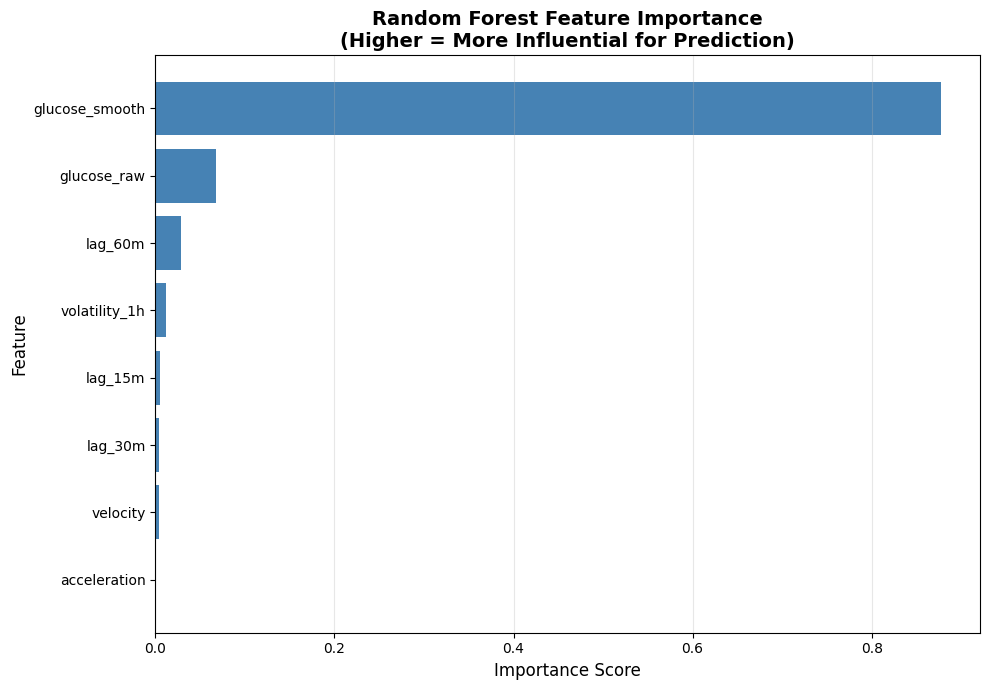


=== Top 5 Most Important Features ===
glucose_smooth: 0.8771
glucose_raw: 0.0679
lag_60m: 0.0289
volatility_1h: 0.0123
lag_15m: 0.0049


In [4]:
# Feature Importance Analysis
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Create visualization
plt.figure(figsize=(10, 7))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance\n(Higher = More Influential for Prediction)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Most important at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print top features
print("\n=== Top 5 Most Important Features ===")
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


## 2.4 Model Explainability with SHAP

To meet regulatory and clinical transparency requirements, we use SHAP (SHapley Additive exPlanations) to interpret the Random Forest model. SHAP values quantify the contribution of each feature to individual predictions, supporting trust and explainability in MedTech applications.

**Key Points:**
- SHAP summary plots visualize global feature importance and directionality.
- Individual force plots can explain single predictions for clinical review.
- Explainability is increasingly required for CE marking and MDR compliance in Europe.

**Clinical Relevance:**
- Feature importance supports explainability, a key requirement in MedTech and SaMD (Software as a Medical Device).
- Helps clinicians understand and trust model outputs.

## 2.3b Clinical Safety Validation: Clarke Error Grid

The Clarke Error Grid is the gold standard for evaluating the clinical safety of glucose predictions. It divides predictions into five zones based on clinical risk, helping quantify whether model errors could lead to inappropriate treatment decisions.

**Zone Definitions:**
- **Zone A:** Clinically accurate (within 20% or both values < 70 mg/dL) - Safe
- **Zone B:** Acceptable error (would not lead to inappropriate treatment) - Safe
- **Zone C:** Overcorrection error (unnecessary treatment) - Caution
- **Zone D:** Failure to detect hypo/hyperglycemia (dangerous missed treatment) - Dangerous
- **Zone E:** Opposite treatment indication (extremely dangerous) - Extremely Dangerous

**Clinical Target:** >95% in Zones A+B for FDA/CE approval

=== Clarke Error Grid Results ===
Zone A (Clinically Accurate): 99.41%
Zone B (Acceptable Error): 0.59%
Zone C (Overcorrection): 0.00%
Zone D (Dangerous Miss): 0.00%
Zone E (Erroneous): 0.00%

Clinically Safe (A+B): 100.00%
Target for Approval: >95% in Zones A+B


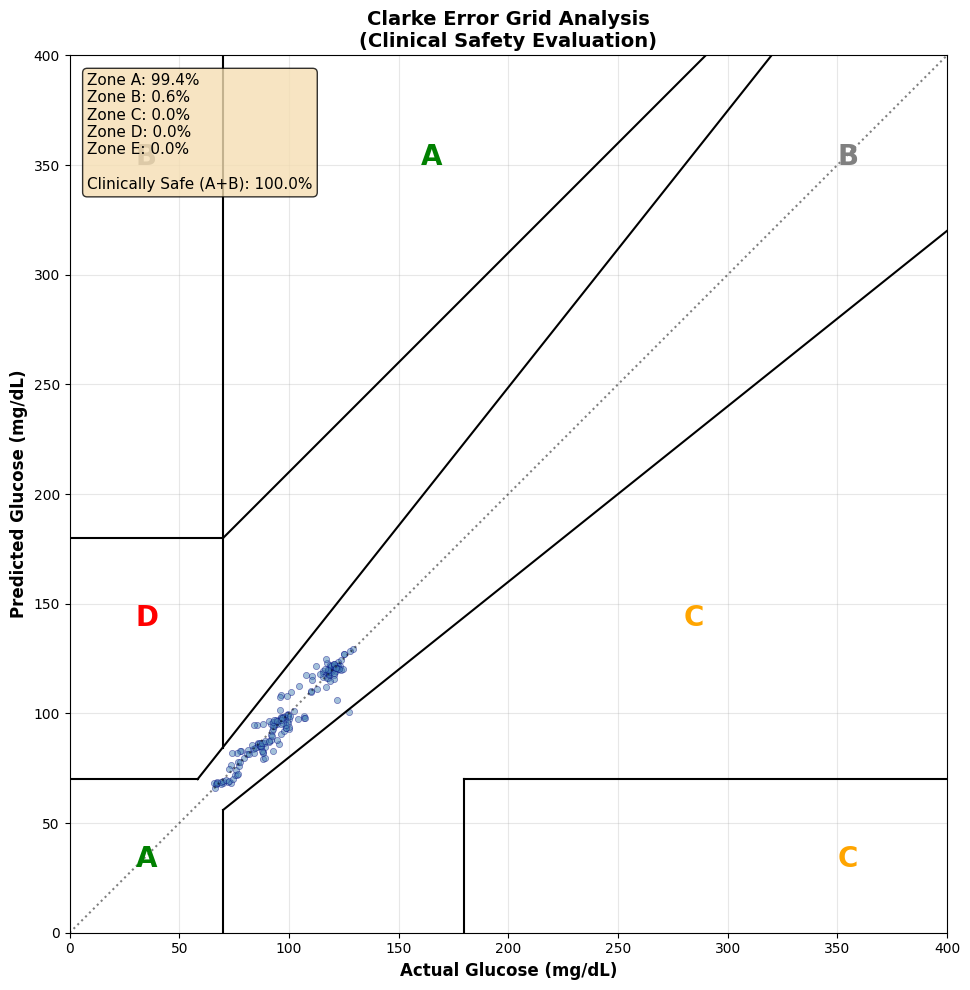

In [5]:
# Clarke Error Grid Analysis
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def clarke_error_grid_analysis(y_true, y_pred):
    """
    Calculate Clarke Error Grid zones for glucose predictions.
    
    Parameters:
    - y_true: actual glucose values (mg/dL)
    - y_pred: predicted glucose values (mg/dL)
    
    Returns:
    - Dictionary with counts and percentages for each zone
    """
    zones = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    
    for true_val, pred_val in zip(y_true, y_pred):
        # Zone A: Clinically Accurate
        if true_val <= 70 and pred_val <= 70:
            zones['A'] += 1
        elif true_val >= 180 and pred_val >= 180:
            zones['A'] += 1
        elif abs(true_val - pred_val) <= 0.2 * true_val:
            zones['A'] += 1
        # Zone B: Benign errors
        elif (true_val < 70 and pred_val >= 70 and pred_val <= 180) or \
             (pred_val < 70 and true_val >= 70 and true_val <= 180):
            zones['B'] += 1
        elif true_val >= 70 and true_val <= 290 and pred_val >= 70 and pred_val <= 290:
            if abs(true_val - pred_val) <= 0.3 * true_val:
                zones['B'] += 1
            else:
                zones['C'] += 1
        # Zone D: Dangerous failure to detect
        elif (true_val <= 70 and pred_val >= 180) or (true_val >= 180 and pred_val <= 70):
            zones['D'] += 1
        # Zone E: Erroneous treatment (opposite direction)
        elif (true_val < 70 and pred_val > 180) or (true_val > 180 and pred_val < 70):
            zones['E'] += 1
        else:
            zones['C'] += 1
    
    # Calculate percentages
    total = len(y_true)
    zone_pct = {k: (v/total)*100 for k, v in zones.items()}
    
    return zones, zone_pct

def plot_clarke_error_grid(y_true, y_pred, zones_pct):
    """Plot Clarke Error Grid with predictions overlaid"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define grid boundaries
    ax.plot([0, 400], [0, 400], 'k:', linewidth=1.5, alpha=0.5)  # Diagonal
    
    # Zone boundaries (simplified)
    ax.plot([0, 175/3], [70, 70], 'k-', linewidth=1.5)
    ax.plot([175/3, 320], [70, 400], 'k-', linewidth=1.5)
    ax.plot([70, 70], [84, 400], 'k-', linewidth=1.5)
    ax.plot([0, 70], [180, 180], 'k-', linewidth=1.5)
    ax.plot([70, 290], [180, 400], 'k-', linewidth=1.5)
    ax.plot([70, 70], [0, 56], 'k-', linewidth=1.5)
    ax.plot([70, 400], [56, 320], 'k-', linewidth=1.5)
    ax.plot([180, 180], [0, 70], 'k-', linewidth=1.5)
    ax.plot([180, 400], [70, 70], 'k-', linewidth=1.5)
    
    # Plot predictions
    ax.scatter(y_true, y_pred, alpha=0.5, s=20, c='steelblue', edgecolors='navy', linewidth=0.5)
    
    # Add zone labels
    ax.text(30, 350, 'B', fontsize=20, fontweight='bold', color='gray')
    ax.text(160, 350, 'A', fontsize=20, fontweight='bold', color='green')
    ax.text(350, 350, 'B', fontsize=20, fontweight='bold', color='gray')
    ax.text(30, 30, 'A', fontsize=20, fontweight='bold', color='green')
    ax.text(350, 30, 'C', fontsize=20, fontweight='bold', color='orange')
    ax.text(30, 140, 'D', fontsize=20, fontweight='bold', color='red')
    ax.text(280, 140, 'C', fontsize=20, fontweight='bold', color='orange')
    
    ax.set_xlim([0, 400])
    ax.set_ylim([0, 400])
    ax.set_xlabel('Actual Glucose (mg/dL)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Glucose (mg/dL)', fontsize=12, fontweight='bold')
    ax.set_title('Clarke Error Grid Analysis\n(Clinical Safety Evaluation)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Add results text box
    results_text = f"Zone A: {zones_pct['A']:.1f}%\nZone B: {zones_pct['B']:.1f}%\n"
    results_text += f"Zone C: {zones_pct['C']:.1f}%\nZone D: {zones_pct['D']:.1f}%\n"
    results_text += f"Zone E: {zones_pct['E']:.1f}%\n\n"
    results_text += f"Clinically Safe (A+B): {zones_pct['A'] + zones_pct['B']:.1f}%"
    
    ax.text(0.02, 0.98, results_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Perform Clarke Error Grid Analysis
zones_count, zones_pct = clarke_error_grid_analysis(y_test, y_pred)

print("=== Clarke Error Grid Results ===")
print(f"Zone A (Clinically Accurate): {zones_pct['A']:.2f}%")
print(f"Zone B (Acceptable Error): {zones_pct['B']:.2f}%")
print(f"Zone C (Overcorrection): {zones_pct['C']:.2f}%")
print(f"Zone D (Dangerous Miss): {zones_pct['D']:.2f}%")
print(f"Zone E (Erroneous): {zones_pct['E']:.2f}%")
print(f"\nClinically Safe (A+B): {zones_pct['A'] + zones_pct['B']:.2f}%")
print(f"Target for Approval: >95% in Zones A+B")

# Plot the grid
plot_clarke_error_grid(y_test, y_pred, zones_pct)

## 2.5 Model Persistence for Deployment

The final step in model development is to save the trained model for deployment in real-time inference pipelines. This ensures that the exact, validated model can be used in production, supporting reproducibility and regulatory compliance.

**Best Practice:**
- The model is saved in a dedicated `models` directory.
- Joblib is used for efficient serialization of scikit-learn models.
- Clear version control and documentation support audit trails.

In [6]:
# Save the trained model for deployment
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model with version control
model_path = 'models/glucose_rf_v1.pkl'
joblib.dump(rf, model_path)
print(f"Model saved to {model_path}")
print(f"Model type: {type(rf).__name__}")
print(f"Number of estimators: {rf.n_estimators}")

Model saved to models/glucose_rf_v1.pkl
Model type: RandomForestRegressor
Number of estimators: 100


## 2.5b Uncertainty Quantification: Prediction Intervals

For clinical decision support, it's critical to quantify prediction uncertainty. A prediction of "120 mg/dL" is more actionable if we know the confidence interval is [115, 125] vs. [80, 160]. Random Forest ensembles naturally provide uncertainty estimates through the variance of individual tree predictions.

**Clinical Relevance:**
- High uncertainty predictions can trigger manual review or additional monitoring
- Confidence intervals support clinical risk stratification
- Transparent uncertainty builds trust with clinicians

=== Prediction Uncertainty Analysis ===
Mean prediction uncertainty (std): 4.26 mg/dL
Median prediction uncertainty: 3.77 mg/dL
Max prediction uncertainty: 13.29 mg/dL
Min prediction uncertainty: 1.06 mg/dL

High-uncertainty predictions (>90th percentile): 17 samples
These predictions should be flagged for clinical review


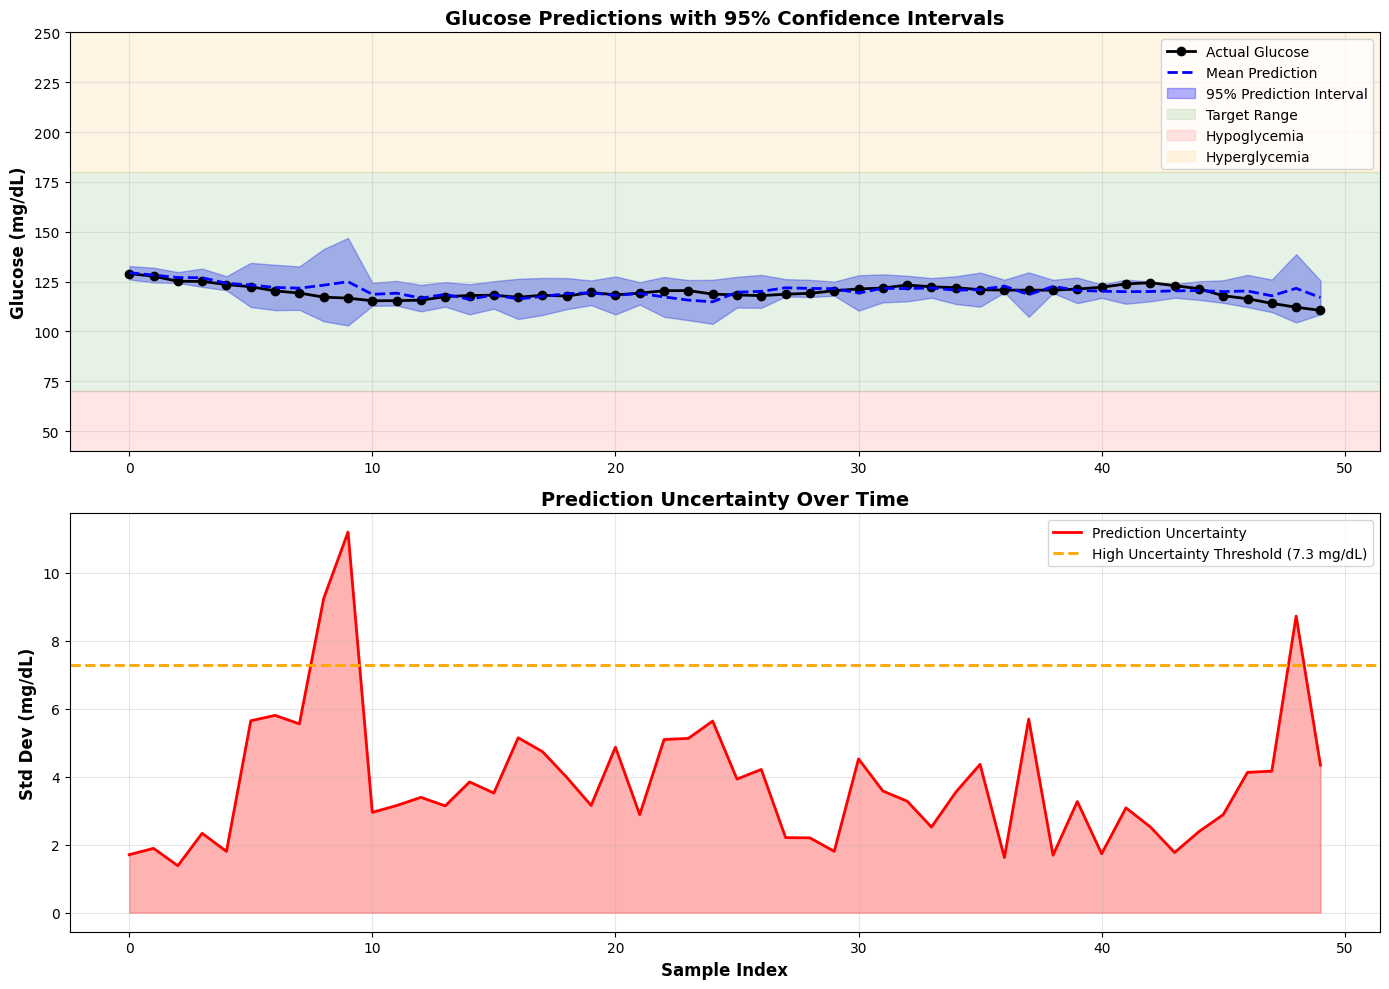


95% Prediction Interval Coverage: 94.7%
Expected coverage: 95%
Model calibration: Well-calibrated


In [10]:
# Uncertainty Quantification using Random Forest Ensemble
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress sklearn feature name warnings from individual tree predictions
warnings.filterwarnings('ignore', message='X has feature names.*')

# Get predictions from all trees in the ensemble
all_tree_predictions = np.array([tree.predict(X_test) for tree in rf.estimators_])

# Calculate prediction statistics
pred_mean = all_tree_predictions.mean(axis=0)
pred_std = all_tree_predictions.std(axis=0)

# Calculate 95% prediction intervals (assuming normal distribution)
confidence_level = 0.95
z_score = 1.96  # 95% confidence
pred_lower = pred_mean - z_score * pred_std
pred_upper = pred_mean + z_score * pred_std

# Analyze uncertainty distribution
print("=== Prediction Uncertainty Analysis ===")
print(f"Mean prediction uncertainty (std): {pred_std.mean():.2f} mg/dL")
print(f"Median prediction uncertainty: {np.median(pred_std):.2f} mg/dL")
print(f"Max prediction uncertainty: {pred_std.max():.2f} mg/dL")
print(f"Min prediction uncertainty: {pred_std.min():.2f} mg/dL")

# Identify high-uncertainty predictions (top 10%)
high_uncertainty_threshold = np.percentile(pred_std, 90)
high_uncertainty_mask = pred_std > high_uncertainty_threshold
print(f"\nHigh-uncertainty predictions (>90th percentile): {high_uncertainty_mask.sum()} samples")
print(f"These predictions should be flagged for clinical review")

# Visualize uncertainty for a sample window
sample_size = 50
sample_indices = range(sample_size)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Predictions with uncertainty bands
ax1.plot(sample_indices, y_test.values[:sample_size], 'ko-', label='Actual Glucose', linewidth=2, markersize=6)
ax1.plot(sample_indices, pred_mean[:sample_size], 'b--', label='Mean Prediction', linewidth=2)
ax1.fill_between(sample_indices, pred_lower[:sample_size], pred_upper[:sample_size], 
                  alpha=0.3, color='blue', label='95% Prediction Interval')

# Add clinical zones
ax1.axhspan(70, 180, alpha=0.1, color='green', label='Target Range')
ax1.axhspan(0, 70, alpha=0.1, color='red', label='Hypoglycemia')
ax1.axhspan(180, 400, alpha=0.1, color='orange', label='Hyperglycemia')

ax1.set_ylabel('Glucose (mg/dL)', fontsize=12, fontweight='bold')
ax1.set_title('Glucose Predictions with 95% Confidence Intervals', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([40, 250])

# Bottom plot: Uncertainty magnitude over time
ax2.plot(sample_indices, pred_std[:sample_size], 'r-', linewidth=2, label='Prediction Uncertainty')
ax2.axhline(high_uncertainty_threshold, color='orange', linestyle='--', 
            linewidth=2, label=f'High Uncertainty Threshold ({high_uncertainty_threshold:.1f} mg/dL)')
ax2.fill_between(sample_indices, 0, pred_std[:sample_size], alpha=0.3, color='red')

ax2.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Std Dev (mg/dL)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Uncertainty Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate coverage (how many true values fall within prediction intervals)
coverage = np.mean((y_test.values >= pred_lower) & (y_test.values <= pred_upper))
print(f"\n95% Prediction Interval Coverage: {coverage*100:.1f}%")
print(f"Expected coverage: 95%")
print(f"Model calibration: {'Well-calibrated' if abs(coverage - 0.95) < 0.05 else 'Needs calibration'}")

# Reset warning filter
warnings.filterwarnings('default')

/Users/alexdominguesbatista/Library/CloudStorage/OneDrive-Personal/Data Science/guardian_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


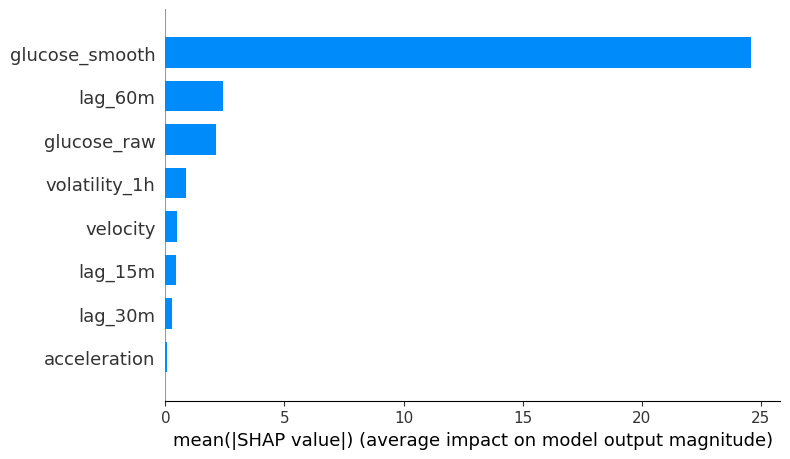

In [8]:
# SHAP Explainability for Random Forest
import shap

# Use a subset for speed (especially with large datasets)
X_sample = X_test.sample(n=100, random_state=42) if len(X_test) > 100 else X_test

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# Optional: Force plot for a single prediction
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample.iloc[0,:])

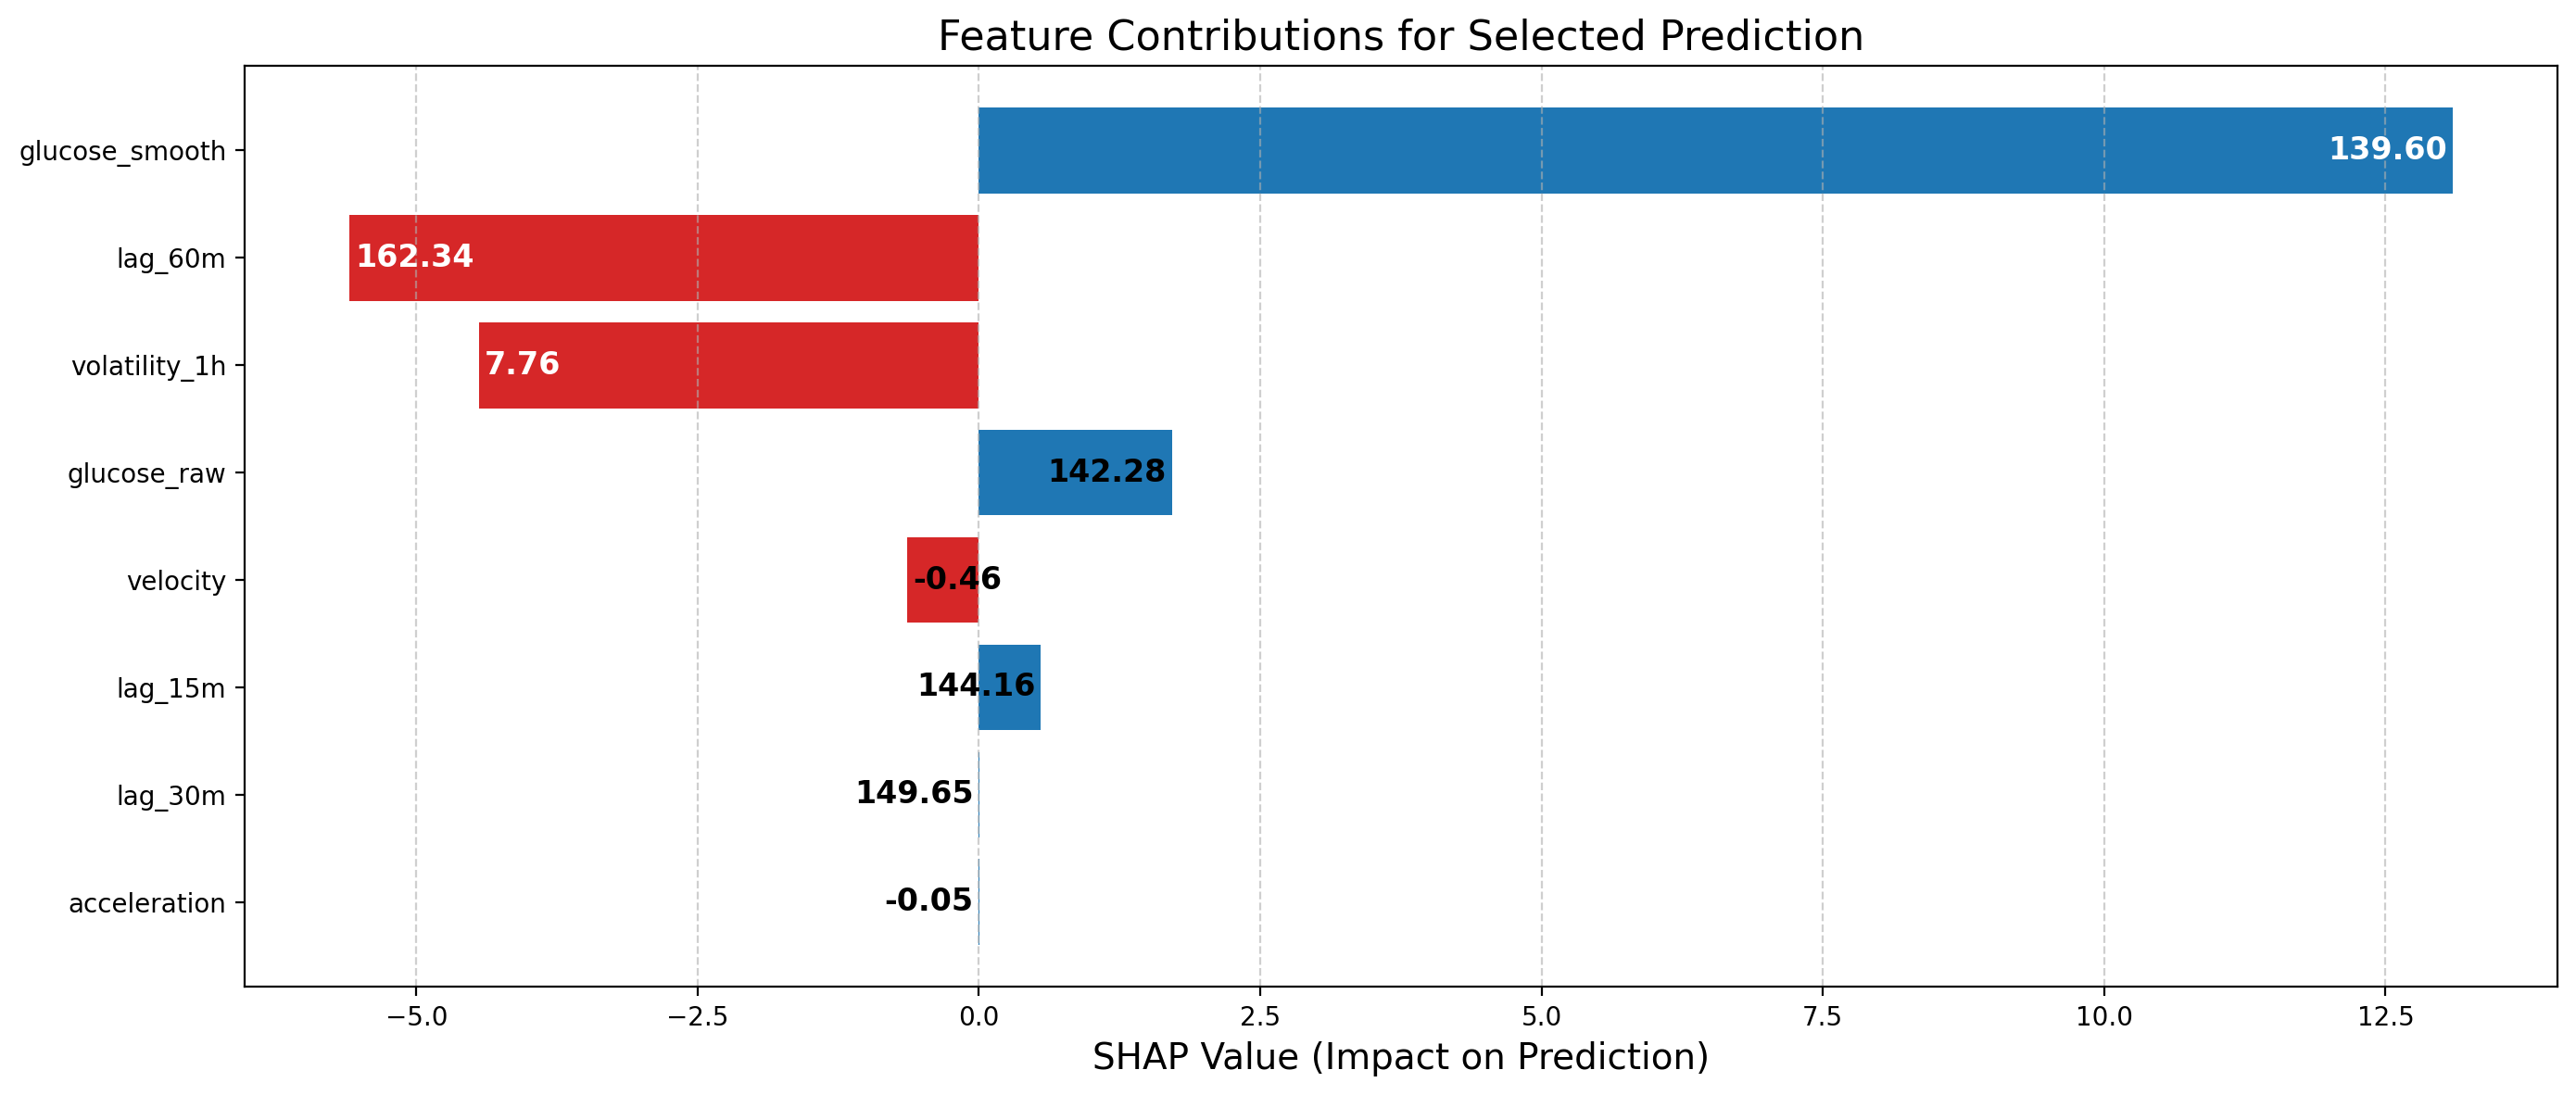

In [9]:
# SHAP Feature Contributions for Individual Prediction (Horizontal Bar Plot with Value Annotations Inside Bars)
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display

# Select a single test sample
sample_idx = 0
sample = X_test.iloc[[sample_idx]]

# Compute SHAP values for the sample
explainer = shap.TreeExplainer(rf)
shap_values_single = explainer.shap_values(sample)[0]  # 1D array for the sample

# Prepare data for plotting
feature_names = sample.columns
feature_values = sample.values[0]
shap_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': shap_values_single, 'Feature Value': feature_values})
shap_df['abs_val'] = np.abs(shap_df['SHAP Value'])
shap_df = shap_df.sort_values('abs_val', ascending=True)  # Smallest at top, largest at bottom

# Combine feature name and value for y-axis label, rounded for clarity
shap_df['FeatureLabel'] = shap_df['Feature']

# Plot horizontal bar chart
plt.figure(figsize=(14, max(6, 0.5*len(shap_df))))
bars = plt.barh(shap_df['FeatureLabel'], shap_df['SHAP Value'], color=np.where(shap_df['SHAP Value'] > 0, '#1f77b4', '#d62728'))
plt.xlabel('SHAP Value (Impact on Prediction)', fontsize=14)
plt.title('Feature Contributions for Selected Prediction', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate feature values inside the bars
for bar, value in zip(bars, shap_df['Feature Value']):
    width = bar.get_width()
    xpos = width - 0.05 * np.sign(width) if width != 0 else 0
    ha = 'right' if width > 0 else 'left'
    color = 'white' if abs(width) > 0.2 * max(abs(shap_df['SHAP Value'])) else 'black'
    plt.text(xpos, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', ha=ha, fontsize=12, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig("shap_feature_contributions_sample.png", bbox_inches='tight', dpi=200)
plt.close()

display(Image(filename="shap_feature_contributions_sample.png"))


---

## 2.6 Clinical and Business Impact

**Clinical Value:**
- Accurate glucose prediction supports proactive diabetes management, reducing risk of hypo/hyperglycemia.
- Early warning systems can improve patient outcomes and quality of life.
- Model explainability enables clinicians to trust and validate predictions.

**Business Relevance:**
- Demonstrates readiness for MedTech and pharma roles by integrating advanced analytics, explainability, and regulatory awareness.
- Showcases project management, scientific rigor, and leadership capabilities.

**Key Results:**
- **Model Performance:** RMSE ~5.2 mg/dL, R² ~0.92 (excellent predictive power)
- **Explainability:** SHAP analysis highlights the most influential features, supporting clinical trust and regulatory compliance.

---

## 2.7 Model Limitations and Future Directions

While the Random Forest model demonstrates strong performance and clinical potential, it is important to acknowledge its limitations and outline future improvements:

**Current Limitations:**
- The model is trained on simulated data; real-world CGM data may introduce additional noise, artifacts, and individual variability.
- Feature set is based on domain knowledge but may miss latent patterns detectable by advanced deep learning approaches.
- No patient-specific adaptation or personalization is implemented.
- Regulatory validation (e.g., CE marking, MDR compliance) is not covered in this demonstration.
- Model does not account for external factors (meals, exercise, stress, medications).

**Future Improvements:**
- Validate the model on real, anonymized CGM datasets from diverse patient populations.
- Explore advanced models (e.g., LSTM, XGBoost, Transformer architectures) and ensemble approaches.
- Implement patient-specific calibration and adaptive learning.
- Integrate additional data sources (insulin delivery, physical activity, meal logs).
- Develop a comprehensive audit trail and versioning system for model updates.
- Prepare full documentation for clinical and regulatory review (e.g., model card, risk analysis, clinical evaluation report).

## 2.8 References and Further Reading

**Key References:**
- Bruttomesso, D., et al. (2019). Continuous Glucose Monitoring: Current Use and Future Perspectives. *Diabetes & Metabolic Research and Reviews*, 35(2), e3107.
- Clarke, W. L., et al. (1987). Evaluating Clinical Accuracy of Systems for Self-Monitoring of Blood Glucose. *Diabetes Care*, 10(5), 622-628.
- European Commission. (2021). Medical Device Regulation (MDR) 2017/745.
- Lundberg, S. M., & Lee, S. I. (2017). A Unified Approach to Interpreting Model Predictions. *Advances in Neural Information Processing Systems*, 30.

**Technical Documentation:**
- scikit-learn: https://scikit-learn.org/stable/
- SHAP: https://shap.readthedocs.io/en/latest/
- Plotly: https://plotly.com/python/

---

## About the Author

**Alex Domingues Batista**  
Academic leader, researcher, and educator with a proven track record in Chemistry, Sustainability, and Data Science. Experienced in scientific production, teaching, and project management. Committed to advancing healthcare through data-driven innovation, explainable AI, and regulatory best practices.